In [2]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import re
import os
import random
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

import warnings
warnings.filterwarnings("ignore")

In [3]:
#functions
def extract_label(label):
    return [b['labels'] for b in label]

def transform_pic_name(pic_name):
    match = re.search(r'(\d+)(?=.jpg)', pic_name)
    if match:
        return match.group(1) + '.jpg'
    return pic_name

def image_to_tensor(img_path):
    img = Image.open(img_path)
    img = img.convert('L')
    
    transform = transforms.Compose([
        transforms.Resize((28, 28)),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomRotation(15),
        #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        #transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    img_tensor = transform(img)
    return img_tensor

def apply_image_to_tensor(row):
    img_path = os.path.join(image_dir, row['pic_name'])
    return image_to_tensor(img_path)

def tensor_to_columns(tensor):
    tensor_list = tensor.view(-1).tolist()
    column_names = [f'pixel_{i+1}' for i in range(len(tensor_list))]
    return pd.Series(tensor_list, index=column_names)

def split_data(df, test_size=0.2, random_state=42):
    X = df.drop(columns=['target'])
    y = df['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [4]:
#Preprocessing
file_path = 'marked_df.csv'
df = pd.read_csv(file_path)

#from marked_df to train_df
df = df.drop(['annotation_id', 'annotator', 'created_at', 'id', 'updated_at', 'lead_time', 'bbox'], axis=1)
df = df.rename(columns={'transcription': 'target', 'ocr': 'pic_name'})
df['label'] = df['label'].apply(ast.literal_eval)
df['label'] = df['label'].apply(extract_label)

train_data = []
for idx, row in df.iterrows():
    for label in row['label']:
        train_data.append({
            'pic_name': row['pic_name'],
            'target': label
        })

train_df = pd.DataFrame(train_data)

#pic_name
train_df['new_pic_name'] = train_df['pic_name'].apply(transform_pic_name)
train_df.drop('pic_name', axis=1, inplace=True)
train_df.rename(columns={'new_pic_name' : 'pic_name'}, inplace=True)
train_df.to_csv('df.csv', index=False)
df = pd.read_csv("df.csv")

#image2tensor
image_dir = 'data/'
df['image_tensor'] = df.apply(apply_image_to_tensor, axis=1)

#target2numeric
label_encoder = LabelEncoder()
df['target'] = label_encoder.fit_transform(df['target'])

#tensor2columns
df_tensor = df['image_tensor'].apply(tensor_to_columns)
df = pd.concat([df, df_tensor], axis=1)
df.drop(columns=['image_tensor', 'pic_name'], inplace=True)
df.to_csv('df.csv', index=False)

df.head()

,target,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783,pixel_784
0,73,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,72,0.992157,0.992157,0.992157,0.992157,1.000000,0.992157,0.992157,0.992157,0.992157,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,71,0.984314,0.984314,0.984314,1.000000,0.984314,1.000000,1.000000,1.000000,1.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,65,0.992157,0.992157,0.992157,0.992157,0.992157,1.000000,1.000000,0.992157,0.992157,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,66,0.992157,0.992157,0.992157,1.000000,0.984314,0.984314,0.992157,1.000000,0.984314,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [5]:
print(df.shape)

(218, 785)


**Model**

In [6]:
X_train, X_val, y_train, y_val = split_data(df)

print(f'Shape X_train: {X_train.shape}')
print(f'Shape X_val: {X_val.shape}')
print(f'Shape y_train: {y_train.shape}')
print(f'Shape y_val: {y_val.shape}')

Shape X_train: (174, 784)
Shape X_val: (44, 784)
Shape y_train: (174,)
Shape y_val: (44,)


In [7]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).view(-1, 1, 28, 28)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).view(-1, 1, 28, 28)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)

In [8]:
class modelCNN(nn.Module):
    def __init__(self, num_classes=74):
        super(modelCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.dropout = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(256 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, num_classes)

        self.pool = nn.AdaptiveAvgPool2d((7, 7))

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)

        x = self.pool(x)
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

model1 = modelCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1.to(device)

modelCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=12544, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=74, bias=True)
  (pool): AdaptiveAvgPool2d(

In [9]:
def train_model(model, train_loader, criterion, optimizer, val_loader, epochs=100, device='cpu', patience=5):
    
    best_val_accuracy, epochs_without_improvement = 0.0, 0
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
        
        train_accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")
        
        val_accuracy = val_model(model, val_loader, device)
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs with no improvement.")
            break
        scheduler.step(val_accuracy)
        
def val_model(model, val_loader, device='cpu'):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_accuracy = 100 * correct / total
    print(f'Validation Accuracy: {val_accuracy:.2f}%')
    return val_accuracy

train_model(model1, train_loader, criterion, optimizer, val_loader, epochs=100, device='cpu', patience=10)

Epoch [1/100], Loss: 6.8999, Train Accuracy: 0.00%
Validation Accuracy: 0.00%
Epoch [2/100], Loss: 5.3190, Train Accuracy: 1.15%
Validation Accuracy: 0.00%
Epoch [3/100], Loss: 4.7478, Train Accuracy: 1.15%
Validation Accuracy: 2.27%
Epoch [4/100], Loss: 4.4655, Train Accuracy: 3.45%
Validation Accuracy: 0.00%
Epoch [5/100], Loss: 4.2036, Train Accuracy: 6.32%
Validation Accuracy: 2.27%
Epoch [6/100], Loss: 4.1996, Train Accuracy: 7.47%
Validation Accuracy: 2.27%
Epoch [7/100], Loss: 4.0667, Train Accuracy: 4.02%
Validation Accuracy: 2.27%
Epoch [8/100], Loss: 3.6725, Train Accuracy: 10.34%
Validation Accuracy: 2.27%
Epoch [9/100], Loss: 3.7613, Train Accuracy: 9.20%
Validation Accuracy: 2.27%
Epoch [10/100], Loss: 3.5531, Train Accuracy: 13.79%
Validation Accuracy: 2.27%
Epoch [11/100], Loss: 3.4127, Train Accuracy: 14.37%
Validation Accuracy: 4.55%
Epoch [12/100], Loss: 3.2637, Train Accuracy: 13.79%
Validation Accuracy: 4.55%
Epoch [13/100], Loss: 3.0986, Train Accuracy: 18.39%
Vali

In [10]:
def show_random_prediction(model, val_loader, device):
    model.eval()
    data_iter = iter(val_loader)
    images, labels = next(data_iter)
    idx = torch.randint(0, images.size(0), (1,)).item()
    img = images[idx].unsqueeze(0).to(device)
    label = labels[idx].to(device)

    with torch.no_grad():
        outputs = model(img)
        _, predicted = torch.max(outputs, 1)
    img = img.squeeze().cpu().numpy()

    if img.ndim == 2:
        img = np.expand_dims(img, axis=-1)
    if img.shape[0] == 3:
        img = np.transpose(img, (1, 2, 0))
        
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Actual: {label.item()}, Predicted: {predicted.item()}')
    plt.show()

| Label | Char | Label | Char | Label | Char | Label | Char | Label | Char | Label | Char | Label | Char | Label | Char |
|-------|------|-------|------|-------|------|-------|------|-------|------|-------|------|-------|------|-------|------|
| 0     | !    | 10    | Б    | 20    | Л    | 30    | Х    | 40    | д    | 50    | о    | 60    | э    | 70    | ҳ    |
| 1     | ,    | 11    | В    | 21    | М    | 31    | Ч    | 41    | е    | 51    | П    | 61    | ю    | 71    | —    |
| 2     | -    | 12    | Г    | 22    | Н    | 32    | Ш    | 42    | ж    | 52    | Р    | 62    | я    | 72    | ”    |
| 3     | .    | 13    | Д    | 23    | О    | 33    | Э    | 43    | з    | 53    | С    | 63    | ё    | 73    | „    |
| 4     | :    | 14    | Е    | 24    | п    | 34    | Ю    | 44    | и    | 54    | Т    | 64    | ў    |
| 5     | ;    | 15    | Ж    | 25    | р    | 35    | Я    | 45    | й    | 55    | у    | 65    | Ғ    |
| 6     | ?    | 16    | З    | 26    | с    | 36    | а    | 46    | к    | 56    | ф    | 66    | ғ    |
| 7     | Ё    | 17    | И    | 27    | т    | 37    | б    | 47    | л    | 57    | х    | 67    | Қ    |
| 8     | Ў    | 18    | Й    | 28    | У    | 38    | в    | 48    | м    | 58    | ч    | 68    | қ    |
| 9     | А    | 19    | К    | 29    | Ф    | 39    | г    | 49    | н    | 59    | ш    | 69    | Ҳ    |

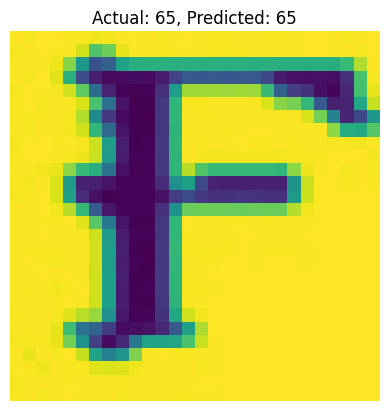

In [25]:
show_random_prediction(model1, val_loader, device='cpu')